# Автокорректор ошибок на Python

На основе блокнота Питера Норвига, Google

In [112]:
%pylab inline
import re
import math
from collections import Counter
import requests

Populating the interactive namespace from numpy and matplotlib


Получим "модель" грамматически правильного текста

In [113]:
TEXT = requests.get('http://norvig.com/big.txt').text
len(TEXT)

6488666

Теперь нужно разбить текст на слова (aka токены). Сосредоточимся только на словах, состоящих из букв. 

In [3]:
def tokens(text):
    """Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте.
    Также приводим текст к нижнему регистру"""
    return re.findall(r'[a-z]+', text.lower())

In [4]:
tokens('This is: A test, 1 , 2, 3. this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [5]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

In [6]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


Сейчас слова появляются в списке в том порядке, как они располагались в тексте.

## Model: Bag of Words

Можем использовать _TEXT_ (список) в качестве *порождающей модели* (generative model) текста. Мы создаём всё же упрощённую модель языка, которая ухватывает часть её сложной структуры. В модели Bag if Words игнорируется порядок слов, но соблюдается частота (представить мешок из игры Лото). Почти наверное полученное предложение из мешка будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частные будут встречаться чаще, более редкие - реже). 
Напишем функцию, которая сэмплирует предложение из n слов с помощью данной модели.

In [7]:
def sample(bag, n=10):
    """Сэмплируем случайную последовательность из n слов из модели, описанной нашим мешком слов."""
    return ' '.join(random.choice(bag) for _ in range(n))

In [8]:
sample(WORDS)

'smiled hour and so at voice of and to associated'

Другое представление мешка слов - Counter. Он содержит в себе ка качестве value кол-во вхождений слова.

In [9]:
Counter(tokens('Is this a test? It is a test'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [10]:
COUNTS = Counter(WORDS)
print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [11]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


В 1935 году лингвист Джордж Ципф отметил, что в любом большом тексте n-ое наиболее часто встречающееся слово появляется с частотой - 1/n от частоты наиболее часто встречающегося слова. Это наблюдение получило название _Закона Ципфа_, несмотря на то, что Феликс Ауэрбах заметил это ещё в 1913 году. Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизительно следовать прямой линии, если закон Ципфа верен.

In [12]:
len(COUNTS)

29157

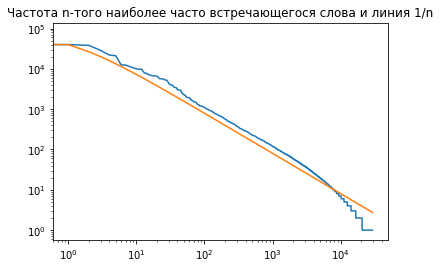

In [13]:
M = COUNTS['the']
yscale('log')
xscale('log')
title('Частота n-того наиболее часто встречающегося слова и линия 1/n')
plot([c for (w, c) in COUNTS.most_common()])
plot([M / i for i in range(1, len(COUNTS))])

## Проверка правописания

**Подход**: найти все кандидаты _c = correct(w)_, достаточно близкие к *w*. Выбрать наиболее вероятный из них.

Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берём слово с максимальной частотой из WORDS. Сейчас измерим близость с помощью расстояния Леверштейна: минимального необходимого количества удалений, перестановок, вставок и замен символов, необходимых, чтобы одно слово превратилось в другое. 

In [14]:
def correct(word):
    """Поиск лучшего исправления ошибки для слова"""
    candidates = (known(edits0(word)) or
                 known(edits1(word)) or
                 known(edits2(word)) or
                 [word])
    return max(candidates, key=COUNTS.get)

In [15]:
def known(words):
    """Вернуть множество слов, которые есть в нашем словаре"""
    return {w for w in words if w in COUNTS}

def edits0(word):
    """Вернуть все строки, которые находятся на edit_distance == 0 от word"""
    return {word}

def edits2(word):
    """Вернуть все строки, которые находятся на edit_distance == 1 от word"""
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [16]:
from string import ascii_lowercase as alphabet

def edits1(word):
    """Возвращает список всех строк на расстоянии edit_distance == 1 от word"""
    pairs = splits(word)
    deletes = [a + b[1:]                     for (a, b) in pairs if b]
    transposes = [a + b[1:] + b[0] + b[2:]   for (a, b) in pairs if len(b) > 1]
    replaces = [a + c + b[1:]                for (a, b) in pairs 
                                                 for c in alphabet if b]
    inserts = [a + c + b                     for (a, b) in pairs 
                                                 for c in alphabet]
    
    return set(deletes + transposes + replaces + inserts)
    
def splits(word):
    """Возвращает список всех возможных разбиений слова на пару (a, b)"""
    return [(word[:i], word[i:]) for i in range(len(word) + 1)]

In [17]:
splits('wirds')

[('', 'wirds'),
 ('w', 'irds'),
 ('wi', 'rds'),
 ('wir', 'ds'),
 ('wird', 's'),
 ('wirds', '')]

In [18]:
print(edits0('wird'))

{'wird'}


In [19]:
print(edits1('wird'))

{'wrd', 'wirh', 'wmird', 'wierd', 'wixrd', 'iwird', 'wiid', 'wirv', 'hird', 'wiqd', 'wircd', 'wira', 'kird', 'wirzd', 'yird', 'wlird', 'wirdl', 'wirq', 'wirdw', 'wirs', 'wipd', 'wfird', 'rird', 'twird', 'wibd', 'qwird', 'dwird', 'wrird', 'wirud', 'wied', 'pwird', 'wkird', 'wirqd', 'wirdb', 'wirx', 'wkrd', 'nird', 'wiod', 'iird', 'wirwd', 'mird', 'dird', 'wimrd', 'whird', 'wirdd', 'wired', 'wxird', 'wiwrd', 'wicd', 'wwird', 'wiird', 'wirdz', 'wire', 'sird', 'wirb', 'wcird', 'wiyd', 'witrd', 'wirde', 'wilrd', 'wirfd', 'wirr', 'mwird', 'wyird', 'wgrd', 'wirdr', 'wnird', 'widr', 'zird', 'wiad', 'wiry', 'aird', 'wdrd', 'wirc', 'awird', 'werd', 'wind', 'wirl', 'hwird', 'cird', 'wbird', 'wirtd', 'wirdh', 'wirjd', 'wirdx', 'wirdf', 'wprd', 'wsird', 'wsrd', 'wirad', 'bird', 'wirdn', 'wirdp', 'witd', 'lird', 'wikd', 'wisrd', 'wlrd', 'wiro', 'jwird', 'wrdid', 'gwird', 'vwird', 'wirdi', 'wirpd', 'wtird', 'wirld', 'wqrd', 'ward', 'wiud', 'wijrd', 'lwird', 'wirdj', 'waird', 'wimd', 'wirf', 'wiri', '

In [20]:
print(len(edits2('wird')))

24953


In [23]:
tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')

['speling',
 'errurs',
 'in',
 'somethink',
 'whutever',
 'unusuel',
 'misteakes',
 'everyware']

In [24]:
list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?')))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

Сделаем выходные данные более приятными.

In [25]:
def correct_text(text):
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    return (str.upper if text.isupper() else
           str.lower if text.islower() else
           str.title if text.istitle() else
           str)

In [28]:
list(map(case_of, ['UPPER', 'lower', 'Title', 'CamelCase']))

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [29]:
correct_text('Speling errurs IN somethink. Whutever; unusuel misteakes everyware?')

'Spelling errors IN something. Whatever; unusual mistakes everywhere?'

## Теория: от счётчика слов к вероятностям последовательностей слов

Нам нужно научиться подсчитывать вероятности слов, _P(w)_. 

In [31]:
def pdist(counter):
    """Превращает частоты из Counter в вероятностное распределение"""
    N = sum(list(counter.values()))
    return lambda x: counter[x] / N

P = pdist(COUNTS)

In [33]:
for w in tokens('"The" is the most common word in English'):
    print(P(w), w)

0.07240666434449033 the
0.008842968103249388 is
0.07240666434449033 the
0.0008215075749693518 most
0.0002596615352601365 common
0.0002696137195383996 word
0.019949605757790978 in
0.00019090098933759167 english


In [36]:
def Pwords(words):
    """Вероятности слов, при условии, что они независимы"""
    return product(P(w) for w in words)

def product(nums):
    """Перемножим числа"""
    result = 1
    for x in nums:
        result *= x
    return result

In [37]:
tests = ['this is a test',
        'this is an unusual test',
        'this is neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

2.983396332800731e-11 this is a test
1.3975923769696695e-16 this is an unusual test
0.0 this is neverbeforeseen test


ВОУ - присвоить последнюю вероятность 0 - неправильно. Она просто должна стремиться к ней. Этот момент рассмотрим позже. Другие вероятности +- адекватные.

## Разбиение слов на сегменты

In [50]:
# декоратор
def memo(f):
    """Запомнить результаты исполнения фуункции f, чьи аргументы args должны быть хешируемыми"""
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

Переиспользование предыдущих результатов - очень инстересная штука.

In [51]:
max(len(w) for w in COUNTS)

18

In [52]:
def splits(text, start=0, L=20):
    """Вернуть список всех пар (a, b); start <= len(a) <= L"""
    return [(text[:i], text[i:])
           for i in range(start, min(len(text), L) + 1)]

In [53]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [54]:
@memo
def segment(text):
    """Вернуть список слов, который является наиболее вероятной сегментацией нашего текста"""
    if not text:
        return []
    else:
        candidates = ([first] + segment(rest)
                     for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [55]:
import time
@memo
def fib(n):
    if n < 2:
        return n
    return fib(n-2) + fib(n-1)

x = 40

t1 = time.perf_counter()
print(f'fib({x}) =', fib(x))
print(time.perf_counter() - t1)

fib(40) = 102334155
0.002422002999992401


In [63]:
segment('speetofart')

['s', 'pe', 'et', 'of', 'art']

In [59]:
Pwords(segment('speedof art'))

0.0

Присутствует проблема переполнения разрядности числа..

In [64]:
segment('smallandinsignificant')

['small', 'and', 'insignificant']

In [65]:
segment('largeandinsignificant')

['large', 'and', 'insignificant']

In [66]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

4.111418791681202e-10
1.0662753919897733e-11


Итого:
- Предположение о мешке слов имеет ряд ограничений;
- Пересчёт pwods на каждом вызове выглядит неэффективным;
- Переполнение чисел возникает для текстов длиннее +- 100 слов, придётся использовать логарифмы или ещё какие-то хитрости.

## Данные: Mo'Data, Mo'Better

Нам мало миллионов слов в "обучающей выборке" давайте перейдем к МИЛЛИАРДАМ слов. Получив такой огромный объем информации, можно перейти к анализу пар последоваительных слов, не ожидая, что вероятности слишком часто будут обнуляться (представьте себе, сколько в языке может быть грамматически корректных сочетаний из двух слов). Мы вновь позаимствуем уже собранные данные у мистера Норвига. Лежат они на его сайте в формате "word \t count" для отдельных слов и в формате "word1 word2 \t count" для биграмм. Считаем их и упакуем в наши словари с вероятностями:

In [67]:
def load_counts(text, sep='\t'):
    """Возвращает Counter, полученный из пар ключ-значение,в каждой строке файла."""
    C = Counter()
    for i in [l.split('\t') for l in text.split('\n')][:-1]:
        key, count = i
        C[key] = int(count)
    return C

In [68]:
COUNTS1 = load_counts(requests.get('https://www.norvig.com/ngrams/count_1w.txt').text)
COUNTS2 = load_counts(requests.get('https://www.norvig.com/ngrams/count_2w.txt').text)

P1w = pdist(COUNTS1)
P2w = pdist(COUNTS2)

In [69]:
print(len(COUNTS1), sum(list(COUNTS1.values()))/1e9)
print(len(COUNTS2), sum(list(COUNTS2.values()))/1e9)

333333 588.124220187
286358 225.955251755


In [70]:
COUNTS2.most_common(30)

[('of the', 2766332391),
 ('in the', 1628795324),
 ('to the', 1139248999),
 ('on the', 800328815),
 ('for the', 692874802),
 ('and the', 629726893),
 ('to be', 505148997),
 ('is a', 476718990),
 ('with the', 461331348),
 ('from the', 428303219),
 ('by the', 417106045),
 ('at the', 416201497),
 ('of a', 387060526),
 ('in a', 364730082),
 ('will be', 356175009),
 ('that the', 333393891),
 ('do not', 326267941),
 ('is the', 306482559),
 ('to a', 279146624),
 ('is not', 276753375),
 ('for a', 274112498),
 ('with a', 271525283),
 ('as a', 270401798),
 ('<S> and', 261891475),
 ('of this', 258707741),
 ('<S> the', 258483382),
 ('it is', 245002494),
 ('can be', 230215143),
 ('If you', 210252670),
 ('has been', 196769958)]

## Теория и Практика: Сегментация с помощью биграмм
Чуть менее неправильная аппроксимация:

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \ldots  \times \ldots P(w_n \mid w_{n-1})$

Эта штука называется биграммной моделью. Представьте, что вы взяли текст, достали из него все возможные пары подряд идущих слов и положили каждую пару в мешок, промаркированный ПЕРВЫМ словом из пары. После этого, чтобы сгенерировать кусок текста, мы берем первое слово из исходного мешка слов , а каждое следующее слово вынимаем из соответствующего мешка биграмм.

Начнем с определения вероятности текущего слова при условии данного предыдущего слова из Counter:

Отмечу, что для английского языка биграммная модель будет выглядеть так:

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times P(w_3 \mid w_2) \ldots  \times \ldots P(w_n \mid w_{n-1})$

условная вероятность слова при условии предыдущего слова определяется так:

$P(w_n \mid w_{n-1}) = P(w_{n-1}w_n) / P(w_{n-1}) $

In [71]:
def Pwords2(words, prev='<S>'):
    "Вероятность последовательности слов с помощью биграммной модели(при условии предыдущего слова)."
    return product(cPword(w, (prev if (i == 0) else words[i-1]) )
                   for (i, w) in enumerate(words))

# Перепишем Pwords на большой словарь P1w вместо Pword
def Pwords(words):
    "Вероятности слов при условии их независимости."
    return product(P1w(w) for w in words)

def cPword(word, prev):
    "Условная вероятность слова при условии предыдущего."
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # если что-то не встретилось, поставим среднее между P1w и 0
        return P1w(word) / 2

In [72]:
print(Pwords(tokens('this is a test')))
print(Pwords2(tokens('this is a test')))
print(Pwords2(tokens('is test a this')))

1.7873982000630825e-10
6.413676294377262e-08
1.1802860036709024e-11


Чтобы сделать segment2, скопируем segment, добавим в аргументы предыдущий токен, а вероятности будем считать с помощью Pwords2 вместо Pwords.

In [73]:
@memo 
def segment2(text, prev='<S>'): 
    "Возвращает наилучшее разбиение текста, используя статистику биграмм." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))

In [74]:
print(segment2('choosespain'))
print(segment2('speedofart'))
print(segment2('smallandinsignificant'))
print(segment2('largeandinsignificant'))

['choose', 'spain']
['speed', 'of', 'art']
['small', 'and', 'in', 'significant']
['large', 'and', 'in', 'significant']


In [75]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
print(segment(adams))
print(segment2(adams))

['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']
['far', 'out', 'in', 'the', 'uncharted', 'backwaters', 'of', 'the', 'unfashionable', 'end', 'of', 'the', 'western', 'spiral', 'arm', 'of', 'the', 'galaxy', 'lies', 'a', 'small', 'un', 'regarded', 'yellow', 'sun']


In [76]:
P1w('unregarded')

0.0

In [77]:
beatles = """Here come old flattop he come grooving up slowly 
          He got joo-joo eyeball he one holy roller 
          He got hair down to his knee 
          Got to be a joker he just do what he please"""
beatles = ''.join(re.findall(r'[a-z]',beatles.lower()))
beatles

'herecomeoldflattophecomegroovingupslowlyhegotjoojooeyeballheoneholyrollerhegothairdowntohiskneegottobeajokerhejustdowhatheplease'

In [78]:
tolkien = 'adrybaresandyholewithnothinginittositdownonortoeat'
print(segment(tolkien))
print(segment2(tolkien))

['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sitdown', 'on', 'or', 'to', 'eat']
['a', 'dry', 'bare', 'sandy', 'hole', 'with', 'nothing', 'in', 'it', 'to', 'sit', 'down', 'on', 'or', 'to', 'eat']


In [79]:
print(segment(beatles))
print(segment2(beatles))

['here', 'come', 'old', 'flattop', 'he', 'come', 'grooving', 'up', 'slowly', 'he', 'got', 'joo', 'joo', 'eyeball', 'he', 'one', 'holy', 'roller', 'he', 'got', 'hair', 'down', 'to', 'his', 'knee', 'got', 'to', 'be', 'a', 'joker', 'he', 'just', 'do', 'what', 'he', 'please']
['here', 'come', 'old', 'flattop', 'he', 'come', 'grooving', 'up', 'slowly', 'he', 'got', 'joo', 'joo', 'eyeball', 'he', 'one', 'holy', 'roller', 'he', 'got', 'hair', 'down', 'to', 'his', 'knee', 'got', 'to', 'be', 'a', 'joker', 'he', 'just', 'do', 'what', 'he', 'please']


## Теория: Валидация

До настоящего момента мы пытались интуитивно оценить результаты нашей работы. Тем не менее, никаких численных оценок качества мы пока не получили. Важно понимать, что без четких метрик слова "плохо"/"хорошо" не имеют никакого смысла. Более того - мы даже не можем четко ответить, было ли наше обновление модели в лучшую сторону или худшую. Обычно при построении неких прогностических моделей данные разбиваются на три части:

1. Обучающая выборка: То, что мы использовали для создания модели исправления ошибок; У нас это был файл big.txt file.
2. Тестовая выборка: Набор данных, который можно использовать для оценки качества вашей модели по ходу разработки.
3. Валидационная выборка: Набор данных, который мы используем для оценки работы программы после того как программа готова. Тестовая выборка для этого быть использована не может—Стоит разработчику посмотреть на результаты на тестовой выборке, она уже "испорчена". В принципе, программист может изменить программу так, чтобы она "подгонялась" под тестовую выборку, а это будет "переобучением". Вот почему нам нужен отдельный набор тестов, который рассматривается только после завершения разработки..

Для нашей программы обучающая выборка - словарь с частотами слов, а тестовая выборка - набор примеров типа "choosespain", на которых мы отлаживались. Остается сделать валидационную выборку.

In [86]:
def test_segmenter(segmenter, tests):
    "Оценка сегментатора на тестовых данных; вывести на печать ошибки; вернуть долю верно разбитого."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(''.join(words))
    correct = (result == words)
    if not correct:
        print('expected', words)
        print('got     ', result) 
    return correct

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it""".splitlines())

In [88]:
test_segmenter(segment, proverbs)

expected ['sticks', 'and', 'stones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']
got      ['stick', 'sandstones', 'may', 'break', 'my', 'bones', 'but', 'words', 'will', 'never', 'hurt', 'me']


(19, 20)

In [90]:
test_segmenter(segment2, proverbs)

(20, 20)

## Теория и Практика: Сглаживание

In [92]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a nongovernmental test',
         'this is a neverbeforeseen test',
         'this is a zqbhjhsyefvvjqc test']

for test in tests:
    print(Pwords(tokens(test)), test)

1.7873982000630825e-10 this is a test
3.7867542527781925e-15 this is a unusual test
1.3117947423493677e-16 this is a nongovernmental test
0.0 this is a neverbeforeseen test
0.0 this is a zqbhjhsyefvvjqc test


Проблема в том, что вероятность одного из слов - 0. Среди этих трех 15-букваенных слов, "nongovernmental" в нашем словаре есть, но если б его не было, вся вероятность бы обнулилась (мы же считаем произведение). Кажется, что это слишком строгое условие; Словарь не идеален и точно существуют реальные слова, которых мы не увидели. Давайте не будем все сразу обнулять. Например точно должна быть оценка вероятности того, что слово настоящее. Скажем, "neverbeforeseen" уж явно более английское чем "zqbhjhsyefvvjqc" и должно иметь бОльшую вероятность.

Проблему можно побороть, присвоив таким "не встретившимся" словам ненулевую вероятность. Еще более важным этот пункт становится при переходе к токенам из нескольких слов (биграммам, например), потому что чем больше слов в токене, тем больше вероятность, что какой-то реальный токен в нашей обучающей выборке отсутствует.

Нашу модель можно представить в виде забора вероятностей, где столбик равен вероятности слова/токена, которое/который в выборке было/был, и равен 0, если слова/токена в выборке не было; Мы хотим сгладить наше распределение вокруг этих пиков, чтобы модель давала какой-то ответ вне зависимости от наличия или отсутствия слова в корпусе. Этот процесс и называется сглаживанием.

Однажды французского математика Лапласа спросили: "Какова вероятность того, что Солнце завтра взойдет?". Из данных, что оно из $n$ ближайших дней взошло $n$ раз следует оценка максимального правдоподобия $n/n$ = 1. Но Лапласу хотелось чуть сбалансировать оценку на шанс того, что завтра Солнце может и не взойти, поэтому он дал оценку $(n + 1) / (n + 2)$.

In [97]:
def pdist_additive_smoothed(counter, c=1):
    """Вероятность слова, при условии данных из Counter'a.
    добавляем c к частоте каждого слова + слово 'unknown'."""
    N = sum(list(counter.values()))          # суммарное кол-во слов
    Nplus = N + c * (len(counter) + 1) # кол-во слов + сглаживание
    return lambda word: (counter[word] + c) / Nplus 

P1w = pdist_additive_smoothed(COUNTS1)

In [98]:
P1w('neverbeforeseen')

1.7003201005861308e-12

Теперь еще одна проблема ... у нас появились незнакомые слова с ненулевой вероятностью.

In [99]:
segment('thisisatestofsegmentationofalongsequenceofwords')

['thisisatestofsegment', 'ationofalongsequence', 'of', 'words']

У нас две проблемы:

Во-первых, у нас нет четкой модели для неизвестных слов. Мы говорим "неизвестное слово", но не различаем более вероятные неизвестные слова и менее вероятные неизвестные слова. Ну, например, вероятнее ли 8-буквенное неизвестное слово чем 20-буквенное неизвестное слово?

Во-вторых, мы не берем в расчет информацию из частей неизвестных слов. Например, "unglobulate" явно должно быть более вероятным чем "zxfkogultae".

Для нашего следующего подхода мы используем идеи метода Гуда - Тьюринга. Он оценивает вероятности слов, не встретившихся в нашем Counter'е, на основании вероятностей слов, встретившихся единожды (Можно туда же подключить вероятности для встретившихся 2 раза и т.д.).

In [100]:
singletons = (w for w in COUNTS if COUNTS[w] == 1)
lengths = list(map(len, singletons))
Counter(lengths).most_common()

[(7, 1357),
 (8, 1356),
 (9, 1175),
 (6, 1113),
 (10, 938),
 (5, 747),
 (11, 627),
 (12, 398),
 (4, 368),
 (13, 215),
 (3, 159),
 (14, 112),
 (2, 51),
 (15, 37),
 (16, 10),
 (17, 7)]

1357 / sum(COUNTS.values())

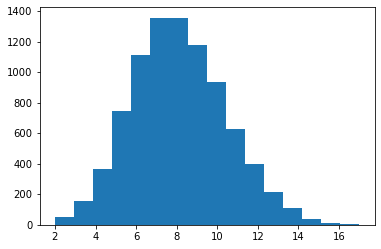

In [101]:
hist(lengths, bins=len(set(lengths)));

In [102]:
def pdist_good_turing_hack(counter, onecounter, base=1/26., prior=1e-8):
    """Вероятность слова при условии данных из счетчика.
    Для неизвестных слов, смотрим на слова, встретившиеся единожды из onecounter, 
    вероятность выбираем, основываясь на длине.
    Воспользуемся идеей метода Гуда-Тьюринга(полностью мы его здесь не реализуем).
    prior -добавочный фактор, который сделает неизвестные слова менее вероятными.
    base -то, насколько мы уменьшаем вероятность за длину слова больше максимального."""
    N = sum(list(counter.values()))
    N2 = sum(list(onecounter.values()))
    lengths = list(map(len, [w for w in onecounter if onecounter[w] == 1]))
    ones = Counter(lengths)
    longest = max(ones)
    return (lambda word: 
            counter[word] / N if (word in counter) 
            else prior * (ones[len(word)] / N2 or 
                          ones[longest] / N2 * base ** (len(word)-longest)))
#Переопределим P1w
P1w = pdist_good_turing_hack(COUNTS1, COUNTS)

In [103]:
segment.cache.clear()
segment('thisisatestofsegmentationofaverylongsequenceofwords')

['this',
 'is',
 'a',
 'test',
 'of',
 'segmentation',
 'of',
 'a',
 'very',
 'long',
 'sequence',
 'of',
 'words']

## Задача: Что если слово находится очень далеко по edit_distance, но звучит точно так же?


(11) Задача: Что если слово находится очень далеко по edit_distance, но звучит точно так же?
Часто можно встретить ошибки в текстах, вызванные неграмотным написанием слов. Особенно часто это происходит в случае иностранных фамилий или транслитерированной терминологии. Обычно в таких случаях в пример приводят написание фамилии

Schwartzenegger

в виде:

Shwarzenegger, Shwortsinneger, schwartzineger ... und so weiter

Для такого случая можно использовать следующую методологию. Давайте привлечем лингвистов и составим правила, которые одинаково звучащим словам будут ставить в соответствие один и тот же код. Допустим, с помощью лингвистов мы такой алгоритм придумали. Тогда дальнейшие наши действия таковы:

1) Сделать словарь с вероятностями слов (как мы делали из мешка слов)

2) Сделать словарь соответствий код слова -> слово (с помощью того самого алгоритма от лингвистов). 
    Если есть в списке есть слова с одинаковым кодом, выбирать будем наиболее частое слово.

3) Сделаем аналогичный edit_distance алгоритм на множестве кодов слов

4) Найдя соответствующую замену для слова в виде его кода, восстановим слово с помощью словаря из пункта 2

Алгоритм, про который мы поговорим, называется Double Metaphone. Примеры есть тут. Перейдем к делу, посмотрим, как это работает.

In [104]:
from metaphone import doublemetaphone

ModuleNotFoundError: No module named 'metaphone'


Алгоритм возвращает кортеж из двух возможных фонетических кодов слова. Правило такое:

- (Primary Key = Primary Key) = Идеальное совпадение
- (Secondary Key = Primary Key) = Совпадение
- (Primary Key = Secondary Key) = Совпадение
- (Alternate Key = Alternate Key) = Совпадение +-

Идельное совпадение

In [105]:
print(doublemetaphone("Günther Graß"))
print(doublemetaphone("Günther Grass"))

NameError: name 'doublemetaphone' is not defined

Совпадение

In [106]:
print(doublemetaphone("schwartzenegger"))
print(doublemetaphone("shwortsineger"))

NameError: name 'doublemetaphone' is not defined

In [107]:
print(doublemetaphone("xerox"))
print(doublemetaphone("zeeerux"))

NameError: name 'doublemetaphone' is not defined

## Немного о динамическом программировании. Насколько дорого превращать одно слово в другое?

Динамическое программирование позволяет разбить задачу на подзадачи, решив которые можно скомпоновать финальное решение. Мы будем пытаться превратить строку source[0..i] в строку target[0..j], мы сосчитаем все возможные комбинации подстрок substrings[i, j] и рассчитаем их edit_distance до нашей исходной. Мы будем сохранять результаты в таблицу и переиспользовать их для расчета дальнейших изменений.

In [109]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: строка-исходник
        target: строка, в которую мы должны исходник превратить
        ins_cost: цена вставки
        del_cost: цена удаления
        rep_cost: цена замены буквы
    Output:
        D: матрица размера len(source)+1 на len(target)+1 содержащая минимальные расстояния edit_distance
        med: минимальное расстояние edit_distance (med), необходимое, 
        чтобы превратить строку source в строку target
    '''
    # стоимость удаления и вставки = 1
    m = len(source)
    n = len(target)

    # Заткнем нашу матрицу нулями
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Заполним первую колонку
    for row in range(1,m+1): 
        D[row,0] = D[row-1,0] + del_cost
        
    # Заполним первую строку
    for col in range(1,n+1): 
        D[0,col] = D[0,col-1] + ins_cost
        
    # Теперь пойдем от 1 к m-той строке
    for row in range(1,m+1): 
        
        # итерируемся по колонкам от 1 до n
        for col in range(1,n+1):
            
            # r_cost - стоимость замены
            r_cost = rep_cost
            
            # Совпадает ли буква исходного слова из предыдущей строки
            # с буквой целевого слова из предыдущей колонки, 
            if source[row-1] == target[col-1]:
                # Если они не нужны, то замена не нужна -> стоимость = 0
                r_cost = 0
                
            # Обновляем значение ячейки на базе предыдущих значений 
            # Считаем D[i,j] как минимум из трех возможных стоимостей (как в формуле выше)
            D[row,col] = min([D[row-1,col]+del_cost, D[row,col-1]+ins_cost, D[row-1,col-1]+r_cost])
          
    # установить edit_distance в значение из правого нижнего угла
    med = D[m,n]
    

    return D, med

In [110]:
import pandas as pd

source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)

print("Расстояние: ",min_edits, "\n")

idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

Расстояние:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4
